# Binary Classification vs. Anomaly Detection with KNN and SVM 

Description of experiment:

- it is assumed you already have a dataset that has been normalized with min-max to scale all the features from 0..1
- dataset contains two classes (normal=0, abnormal=1) 
- 2000 rows of normal data, 200 rows of abnormal data
- The procedure is shown in the graphic below. Both the normal traffic and the anomaly traffic data are downsampled to, on the one hand, keep some anomaly traffic for the final validation stage; on the second hand, the downsampling allows us to obtain a balanced data set for training the two-classes problems.
- The remaining data not used in the training and testing of the models is preserved for the final validation stage.
- Once the data is downsampled, it is normalized and a 10-fold cross validation is carried out independently for the two-classes problem and for the one-class problem, although the same random seed is used to obtain the same partitions in each case for comparison reasons. 
- In the two-classes problem, all the partitions may include normal and anomaly instances. However, in the one-class problem, the partitions are prepared only with the normal traffic instances; the anomaly instances are used to measure the performance of the models obtained for each fold. Interestingly, the normalization for the one-class problem is determined exclusively with data from normal traffic only.
- A final validation stage includes all the data that has not been used in training and testing; this is an unbalanced data set containing instances from normal traffic and from anomalies. 
- The aim of this validation stage is to compare the behavior of the different modeling techniques included in this comparison, so conclusions could be extracted.
- the "normal" traffic (2000 lines) is the "negative class", while the "abnormal" traffic (200 lines) is the "positive class"



## Design of experiment
<img src=https://raw.githubusercontent.com/nickjeffrey/sklearn/master/images/fig03_experimental_setup.png>

In [1]:
# This jupyter notebook is based on # Stat479: Machine Learning -- L02: kNN in Python
# https://github.com/rasbt/stat479-machine-learning-fs18/blob/master/02_knn/02_knn_demo.ipynb


# 1 - choose the learning algorithm (KNN, SVM)


In [2]:
# adjust the modeltype=KNN|SVM variable to run different algorithms

#modeltype="TwoClassKNN"   #adjust this variable to run the subsequent steps using the SVM or KNN algorithms
modeltype="TwoClassSVM"  #adjust this variable to run the subsequent steps using the SVM or KNN algorithms
#modeltype="OneClassSVM"  #adjust this variable to run the subsequent steps using the SVM or KNN algorithms
#modeltype="OneClassKNN"  #adjust this variable to run the subsequent steps using the SVM or KNN algorithms


print ("The subsequent steps in this jupyter notebook will use the", modeltype,"algorithm")

The subsequent steps in this jupyter notebook will use the TwoClassSVM algorithm


# 2 - Import required packages



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math  #get square root function


from sklearn.neighbors import KNeighborsClassifier  #2-class (supervised, with labels) 
from sklearn import svm                             #2-class (supervised, with labels)
from sklearn.svm import OneClassSVM                 #1-class (unsupervised, no labels)
from sklearn.neighbors import NearestNeighbors      #1-class (unsupervised, no labels)

from sklearn.preprocessing   import MinMaxScaler
from sklearn.metrics         import confusion_matrix
from sklearn.model_selection import StratifiedKFold    #for cross-validation
from sklearn.model_selection import GridSearchCV       #for cross-validation


# 3 - Load Dataset into a Pandas DataFrame


In [4]:
#df_data = pd.read_csv('c:/temp/data4.csv')
#df_data = pd.read_csv('c:/temp/data5.csv')  #overwrote 100 lines of abnormal data with normal data to skew results
#df_data = pd.read_csv('c:/temp/data7.csv')  # this data has not been scaled/normalized
df_data = pd.read_csv('https://raw.githubusercontent.com/nickjeffrey/sklearn/master/dataset.csv')

In [5]:
# look at the top few rows of the data (should show the abnormal class in column 35)
df_data.head()

,seconds_since_epoch,datestamp,sp1_watts_generated,sp2_watts_generated,sp3_watts_generated,iot_gateway_watt_consumption,water_pump_watt_consumption,valve1_watt_consumption,valve2_watt_consumption,valve3_watt_consumption,...,temps3_soil_temperature_C,latency_iotgateway_ms,latency_logcollector_ms,packetloss_iotgateway,packetloss_logcollector,auth_success_mqtt_to_hmi,auth_failure_mqtt_to_hmi,auth_success_ssh_to_iogateway,auth_failure_ssh_to_iotgateway,class
0,1673334002,1/10/2023 0:00,0.0,0.0,0.0,1.63,0.0,0.32,0.12,0.10,...,23.76,1.423,0.527,6.46,4.96,11,8,4,4,abnormal
1,1673334062,1/10/2023 0:01,0.0,0.0,0.0,1.12,0.0,0.03,0.16,0.10,...,16.74,1.505,1.117,5.10,5.61,15,13,11,5,abnormal
2,1673334122,1/10/2023 0:02,0.0,0.0,0.0,0.28,0.0,0.15,0.00,0.31,...,13.50,0.137,0.187,4.47,4.64,3,7,8,6,abnormal
3,1673334182,1/10/2023 0:03,0.0,0.0,0.0,1.16,0.0,0.26,0.08,0.16,...,9.36,1.240,0.754,5.16,5.22,3,7,11,10,abnormal
4,1673334242,1/10/2023 0:04,0.0,0.0,0.0,0.97,0.0,0.32,0.31,0.15,...,21.60,1.336,0.386,5.49,3.55,9,14,3,7,abnormal


In [6]:
# look at the bottom few rows of the data (should show the normal class in column 35)
df_data.tail()

,seconds_since_epoch,datestamp,sp1_watts_generated,sp2_watts_generated,sp3_watts_generated,iot_gateway_watt_consumption,water_pump_watt_consumption,valve1_watt_consumption,valve2_watt_consumption,valve3_watt_consumption,...,temps3_soil_temperature_C,latency_iotgateway_ms,latency_logcollector_ms,packetloss_iotgateway,packetloss_logcollector,auth_success_mqtt_to_hmi,auth_failure_mqtt_to_hmi,auth_success_ssh_to_iogateway,auth_failure_ssh_to_iotgateway,class
2195,1673453753,9:15,32.72,32.85,32.22,0.90,0.0,0.16,0.18,0.18,...,20.2,0.520,0.459,0.0,0.0,1,0,0,0,normal
2196,1673453813,9:16,27.34,30.48,29.71,0.78,0.0,0.16,0.19,0.19,...,20.6,0.483,0.612,0.0,0.0,1,0,1,1,normal
2197,1673453873,9:17,27.96,28.65,28.04,0.78,0.0,0.23,0.21,0.21,...,20.6,0.356,0.567,0.0,0.0,1,0,1,0,normal
2198,1673453933,9:18,33.00,30.94,29.79,0.89,0.0,0.18,0.23,0.22,...,19.2,0.397,0.641,0.0,0.0,1,0,3,1,normal
2199,1673453993,9:19,31.08,32.72,31.65,0.76,0.0,0.17,0.23,0.16,...,20.8,0.406,0.465,0.0,0.0,1,0,3,1,normal


In [7]:
# show number of rows in dataset
print ("Rows in dataset:")
print ( len(df_data) )


Rows in dataset:
2200


In [8]:
#view dimensions of dataset (rows and columns)
print ("Rows,columns in dataset:")
df_data.shape  

Rows,columns in dataset:


(2200, 35)

In [9]:
# check to see if there are any missing values from the dataset

# all of the results should be zero, which would indicate there are not any null values in the dataset
# if there are any results greater than zero, it would indicate that some pieces of data are missing and should be cleaned up.
df_data.isnull().sum()

seconds_since_epoch               0
datestamp                         0
sp1_watts_generated               0
sp2_watts_generated               0
sp3_watts_generated               0
iot_gateway_watt_consumption      0
water_pump_watt_consumption       0
valve1_watt_consumption           0
valve2_watt_consumption           0
valve3_watt_consumption           0
ms1_watt_consumption              0
ms2_watt_consumption              0
ms3_watt_consumption              0
temp1_watt_consumption            0
temp2_watt_consumption            0
temp3_watt_consumption            0
battery_watt_hours                0
valve1_litres                     0
valve2_litres                     0
valve3_litres                     0
ms1_soil_moisture_pct             0
ms2_soil_moisture_pct             0
ms3_soil_moisture_pct             0
temps1_soil_temperature_C         0
temps2_soil_temperature_C         0
temps3_soil_temperature_C         0
latency_iotgateway_ms             0
latency_logcollector_ms     

In [10]:
# show frequency distribution of values in variables
# this shows how many different values are in each feature
# HINT: this would be more useful to display in a histogram.  For example, bin values 1-10 in one column, 2-20 in next column, etc

#for var in df_data.columns:
#    print(df_data[var].value_counts())

    

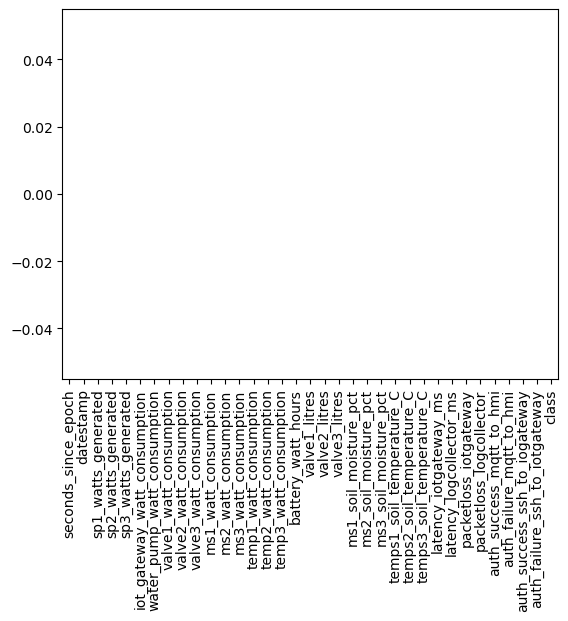

In [11]:
# visualize any missing values from the dataset in a histogram
# you want all the bars in the graph to be zero, which would indicate zero missing values

df_data.isnull().sum().plot.bar()
plt.show()

In [12]:
# another method to visalize missing values from dataset

print ("Checking for missing values in data set")

import matplotlib.pyplot as plt
def plot_nas(df_data: pd.DataFrame):
    if df_data.isnull().sum().sum() != 0:
        na_df = (df_data.isnull().sum() / len(df)) * 100      
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        missing_data.plot(kind = "barh")
        plt.show()
    else:
        print('No NAs found')
plot_nas(df_data)

Checking for missing values in data set
No NAs found


In [13]:
#show the names of the columns (also called feature names)
df_data.columns

Index(['seconds_since_epoch', 'datestamp', 'sp1_watts_generated',
       'sp2_watts_generated', 'sp3_watts_generated',
       'iot_gateway_watt_consumption', 'water_pump_watt_consumption',
       'valve1_watt_consumption', 'valve2_watt_consumption',
       'valve3_watt_consumption', 'ms1_watt_consumption',
       'ms2_watt_consumption', 'ms3_watt_consumption',
       'temp1_watt_consumption', 'temp2_watt_consumption',
       'temp3_watt_consumption', 'battery_watt_hours', 'valve1_litres',
       'valve2_litres', 'valve3_litres', 'ms1_soil_moisture_pct',
       'ms2_soil_moisture_pct', 'ms3_soil_moisture_pct',
       'temps1_soil_temperature_C', 'temps2_soil_temperature_C',
       'temps3_soil_temperature_C', 'latency_iotgateway_ms',
       'latency_logcollector_ms', 'packetloss_iotgateway',
       'packetloss_logcollector', 'auth_success_mqtt_to_hmi',
       'auth_failure_mqtt_to_hmi', 'auth_success_ssh_to_iogateway',
       'auth_failure_ssh_to_iotgateway', 'class'],
      dtype='obje

In [14]:
#show summary info about dataset
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   seconds_since_epoch             2200 non-null   int64  
 1   datestamp                       2200 non-null   object 
 2   sp1_watts_generated             2200 non-null   float64
 3   sp2_watts_generated             2200 non-null   float64
 4   sp3_watts_generated             2200 non-null   float64
 5   iot_gateway_watt_consumption    2200 non-null   float64
 6   water_pump_watt_consumption     2200 non-null   float64
 7   valve1_watt_consumption         2200 non-null   float64
 8   valve2_watt_consumption         2200 non-null   float64
 9   valve3_watt_consumption         2200 non-null   float64
 10  ms1_watt_consumption            2200 non-null   float64
 11  ms2_watt_consumption            2200 non-null   float64
 12  ms3_watt_consumption            22

In [15]:
# show data types 
df_data.dtypes

seconds_since_epoch                 int64
datestamp                          object
sp1_watts_generated               float64
sp2_watts_generated               float64
sp3_watts_generated               float64
iot_gateway_watt_consumption      float64
water_pump_watt_consumption       float64
valve1_watt_consumption           float64
valve2_watt_consumption           float64
valve3_watt_consumption           float64
ms1_watt_consumption              float64
ms2_watt_consumption              float64
ms3_watt_consumption              float64
temp1_watt_consumption            float64
temp2_watt_consumption            float64
temp3_watt_consumption            float64
battery_watt_hours                float64
valve1_litres                     float64
valve2_litres                     float64
valve3_litres                     float64
ms1_soil_moisture_pct             float64
ms2_soil_moisture_pct             float64
ms3_soil_moisture_pct             float64
temps1_soil_temperature_C         

# 4 - dimensionality reduction by removing features without predictive value

In [16]:
# drop any redundant columns from the dataset which does not have any predictive power. 

#In this example, seconds_since_epoch and datestamp do not have any predictive value because they are just timestamps
df_data.drop('seconds_since_epoch', axis=1, inplace=True)
df_data.drop('datestamp', axis=1, inplace=True)

# the water pump only runs for a brief period once per day, filling up a reservoir holding tank
# the values are zero for most of the day, so this feature has limited predictive value
df_data.drop('water_pump_watt_consumption', axis=1, inplace=True)


# These columns are for ping packet loss.  
# If the value is ever >0, the data will be in the "abnormal" class.
# In other words, this allows the learning model to "cheat" by ignoring all the other features if this value is ever >0
# So, this particular data feature should be tracked not with machine learning, but with a simple threshold-based detection.
df_data.drop('packetloss_iotgateway', axis=1, inplace=True)
df_data.drop('packetloss_logcollector', axis=1, inplace=True)


# Same issue as the previous ping features.
# These colums are for machine-to-machine data transfers, if the authentication failures are ever >0, the data is abnormal
# In other words, this allows the learning model to "cheat" by ignoring all the other features if this value is ever >0
# So, this particular data feature should be tracked not with machine learning, but with a simple threshold-based detection.
df_data.drop('auth_failure_mqtt_to_hmi', axis=1, inplace=True)
df_data.drop('auth_failure_ssh_to_iotgateway', axis=1, inplace=True)


In [17]:
#Look at the dataset again, you should see several columns have been dropped
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   sp1_watts_generated            2200 non-null   float64
 1   sp2_watts_generated            2200 non-null   float64
 2   sp3_watts_generated            2200 non-null   float64
 3   iot_gateway_watt_consumption   2200 non-null   float64
 4   valve1_watt_consumption        2200 non-null   float64
 5   valve2_watt_consumption        2200 non-null   float64
 6   valve3_watt_consumption        2200 non-null   float64
 7   ms1_watt_consumption           2200 non-null   float64
 8   ms2_watt_consumption           2200 non-null   float64
 9   ms3_watt_consumption           2200 non-null   float64
 10  temp1_watt_consumption         2200 non-null   float64
 11  temp2_watt_consumption         2200 non-null   float64
 12  temp3_watt_consumption         2200 non-null   f

In [18]:
# look at the dimensions (rows and columns) of the dataset again after removing a few colums
#view dimensions of dataset (rows and columns)
print ("Rows,columsn in dataset:")
df_data.shape  

Rows,columsn in dataset:


(2200, 28)

# 5 - Get Features into a NumPy Array

In [19]:

#X = df_data[['latency_iotgateway_ms', 'latency_logcollector_ms']].values
X = df_data.values  #assign the entire dataframe to X

# Drop the "class" column from this array because we only want the data with predictive values, 
# and the "class" column is the binary classifier

# [rows,colums], so in this example, do nothing with the rows (before the first comma), 
# use negative indexing -1 to drop the last column
X = X[:,:-1]



In [20]:
# sanity check, look at the first 1 rows, all columns
# since the data has not been scaled/normalized yet, you will see values larger than 1
#X[:1, :]  #slicing
#X[0]  #indexing
X


array([[0.0, 0.0, 0.0, ..., 0.527, 11, 4],
       [0.0, 0.0, 0.0, ..., 1.117, 15, 11],
       [0.0, 0.0, 0.0, ..., 0.187, 3, 8],
       ...,
       [27.96, 28.65, 28.04, ..., 0.567, 1, 1],
       [33.0, 30.94, 29.79, ..., 0.641, 1, 3],
       [31.08, 32.72, 31.65, ..., 0.465, 1, 3]], dtype=object)

# 6 - perform feature scaling with MinMaxScaler


In [21]:
# take all the values in the X array and scale them to values between 0 and 1 
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
# https://scikit-learn.org/stable/auto_examples/applications/plot_digits_denoising.html#sphx-glr-auto-examples-applications-plot-digits-denoising-py

X = MinMaxScaler(feature_range=(0,1)).fit_transform(X)


In [22]:
# sanity check, look at the first 1 rows, all columns
# since the data has been scaled/normalized, all the values will be between 0 and 1
X[:1, :]  #slicing a 2-dimensional array (keeps the shape)


array([[0.        , 0.        , 0.        , 0.98717949, 0.96969697,
        0.375     , 0.3030303 , 0.42857143, 0.14285714, 0.28571429,
        0.28571429, 0.71428571, 0.42857143, 0.47031739, 0.57697121,
        0.34230288, 0.31308704, 0.75488163, 0.78494168, 0.43921038,
        0.65853659, 0.24944568, 0.81634938, 0.91806452, 0.27349081,
        0.58823529, 0.36363636]])

Alternatively, instead of using MinMaxScaler, you can use StandardScaler,
which creates a mean of 0, standard deviation of 1, with normal distribution.
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
 

 

# 7 - Get Class Labels into a NumPy array


In [23]:
# This will add a new column called "ClassLabel", which converts the "normal|abnormal" 
# alphabetic content of the "class" column to an integer
# 2-class models do not assume discrete values for each class, often normal=0, abnormal=1 is used, 
# but we will use -1 and 1 because the unsupervised class wants those values
# 1-class models assume normal=-1, abnormal=1  (but these values also work for supervised models)

label_dict = {'normal': 1, 'abnormal': -1}

df_data['ClassLabel'] = df_data['class'].map(label_dict)


In [24]:
# look at the top few rows of the data (should show the abnormal class in the last column)
df_data.head()

,sp1_watts_generated,sp2_watts_generated,sp3_watts_generated,iot_gateway_watt_consumption,valve1_watt_consumption,valve2_watt_consumption,valve3_watt_consumption,ms1_watt_consumption,ms2_watt_consumption,ms3_watt_consumption,...,ms3_soil_moisture_pct,temps1_soil_temperature_C,temps2_soil_temperature_C,temps3_soil_temperature_C,latency_iotgateway_ms,latency_logcollector_ms,auth_success_mqtt_to_hmi,auth_success_ssh_to_iogateway,class,ClassLabel
0,0.0,0.0,0.0,1.63,0.32,0.12,0.10,0.03,0.01,0.02,...,69.53,20.88,13.50,23.76,1.423,0.527,11,4,abnormal,-1
1,0.0,0.0,0.0,1.12,0.03,0.16,0.10,0.03,0.01,0.01,...,29.00,13.86,16.56,16.74,1.505,1.117,15,11,abnormal,-1
2,0.0,0.0,0.0,0.28,0.15,0.00,0.31,0.00,0.01,0.04,...,14.33,23.40,14.22,13.50,0.137,0.187,3,8,abnormal,-1
3,0.0,0.0,0.0,1.16,0.26,0.08,0.16,0.05,0.04,0.05,...,13.99,13.32,23.94,9.36,1.240,0.754,3,11,abnormal,-1
4,0.0,0.0,0.0,0.97,0.32,0.31,0.15,0.06,0.03,0.04,...,12.28,14.22,20.34,21.60,1.336,0.386,9,3,abnormal,-1


In [25]:
# look at the bottom few rows of the data (should show the normal class in the last column)
df_data.tail()

,sp1_watts_generated,sp2_watts_generated,sp3_watts_generated,iot_gateway_watt_consumption,valve1_watt_consumption,valve2_watt_consumption,valve3_watt_consumption,ms1_watt_consumption,ms2_watt_consumption,ms3_watt_consumption,...,ms3_soil_moisture_pct,temps1_soil_temperature_C,temps2_soil_temperature_C,temps3_soil_temperature_C,latency_iotgateway_ms,latency_logcollector_ms,auth_success_mqtt_to_hmi,auth_success_ssh_to_iogateway,class,ClassLabel
2195,32.72,32.85,32.22,0.90,0.16,0.18,0.18,0.03,0.03,0.03,...,74.36,20.4,20.6,20.2,0.520,0.459,1,0,normal,1
2196,27.34,30.48,29.71,0.78,0.16,0.19,0.19,0.03,0.03,0.03,...,68.43,19.6,20.6,20.6,0.483,0.612,1,1,normal,1
2197,27.96,28.65,28.04,0.78,0.23,0.21,0.21,0.03,0.03,0.04,...,80.55,20.2,19.0,20.6,0.356,0.567,1,1,normal,1
2198,33.00,30.94,29.79,0.89,0.18,0.23,0.22,0.03,0.03,0.04,...,76.16,19.2,20.4,19.2,0.397,0.641,1,3,normal,1
2199,31.08,32.72,31.65,0.76,0.17,0.23,0.16,0.04,0.03,0.03,...,68.44,20.0,19.8,20.8,0.406,0.465,1,3,normal,1


In [26]:

# define the Class Labels (should be -1 normal or 1 for abnormal)
y = df_data['ClassLabel'].values

#show the first 5 rows of the y array (which holds the classifier -1 or 1)
y[:5]  

array([-1, -1, -1, -1, -1], dtype=int64)

In [27]:
#show the last 5 rows of the y array (which holds the classifier -1 or 1)
y[-5:]  

array([1, 1, 1, 1, 1], dtype=int64)

# 8 - Shuffle Dataset and Create Training and Test Subsets


In [28]:
# count the size of the dataset (number of rows)

indices = np.arange(y.shape[0])
indices

array([   0,    1,    2, ..., 2197, 2198, 2199])

In [29]:
# randomize the dataset before splitting
# this is a seeded deterministic shuffle 
# in this example, a seed value of 123 is given, which makes the output deterministic, so the experiment is reproducible
# any seed value can be chosen, but it should remain consistent so the results can be reproduced

rnd = np.random.RandomState(123)
shuffled_indices = rnd.permutation(indices)
shuffled_indices

array([ 809,  403,  304, ..., 1766, 1122, 1346])

In [30]:
# before we shuffle the data, downsample the "abnormal" or "positive" class down, 
# by splitting the 200 lines to 160/40 (aka 80%/20%)

# shuffle within the positive and negative classes to avoid bias
# create a new array that only includes the first 200 rows
X_pos = X[:200]  #implies from beginning up to (but not including) 200
X_neg = X[200:]  #implies from 200 to end
y_pos = y[:200]  #contains the "ClassLabel" feature which will be 0 for negative, 1 for positive
y_neg = y[200:]  #contains the "ClassLabel" feature which will be 0 for negative, 1 for positive

# or use this shortcut, more readable version of the above
#X_pos,y_pos = X[:200],y[:200]
#X_neg,y_neg = X[200:],y[200:]


# shuffle the positive indices (this is the "anomaly" data)
indices_pos = np.arange(X_pos.shape[0])  # or use the len function to get the number of elements in the array len(X_pos)
pos_shuffled_indices = rnd.permutation(indices_pos)
X_pos_shuffled = X_pos[pos_shuffled_indices]
y_pos_shuffled = y_pos[pos_shuffled_indices]


# shuffle the negative indices (this is the "normal" data)
indices_neg = np.arange(X_neg.shape[0])
neg_shuffled_indices = rnd.permutation(indices_neg)
X_neg_shuffled = X_neg[neg_shuffled_indices]
y_neg_shuffled = y_neg[neg_shuffled_indices]


# split the data between test and train
# grab the first 40 lines (20%) of the abormal (positive) class for test data 
X_test_pos, y_test_pos = X_pos_shuffled[:40],y_pos_shuffled[:40] 

# grab the last 160 lines (80%) of the abnormal (positive) class for training data
X_train_pos, y_train_pos = X_pos_shuffled[40:],y_pos_shuffled[40:]  #only the starting row is shown, last row (200) is implied

# we want the abnormal/normal classes to be balanced, so grab the same amount of data (160 lines) as the previous step
# rows 0 to 160 will be the first 160 lines of the "normal" or negative class
# first value is included, last value is not included :160 means 0 is implied, 160 is *not* included
X_train_neg, y_train_neg = X_neg_shuffled[:160],y_neg_shuffled[:160]

# the remaining lines are for test
X_test_neg, y_test_neg = X_neg_shuffled[160:],y_neg_shuffled[160:] 






In [31]:
# sanity check to visualize the labels, make sure the classLabel boundaries are correct
# this confirms that we split up the data correcly into training data and test data in the previous step

print ("y testing data for positive/abnormal class, should be all -1:")
print (y_test_pos)   # should output all 1
print ("")
print ("y testing data for negative/normal class, should be all +1:")
print (y_test_neg)   # should output all 0
print ("")
print ("y training data for positive/abnormal class, should be all -1:")
print (y_train_pos)  # should output all 1
print ("")
print ("y training data for negative/normal class, should be all +1:")
print (y_train_neg)  # should output all 0

y testing data for positive/abnormal class, should be all -1:
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]

y testing data for negative/normal class, should be all +1:
[1 1 1 ... 1 1 1]

y training data for positive/abnormal class, should be all -1:
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]

y training data for negative/normal class, should be all +1:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

In [32]:
# create the training set and test set

#concatentate the 2 python arrays of positive and negative classes into a single array that will be used to train the model
X_train = np.concatenate((X_train_pos,X_train_neg))
y_train = np.concatenate((y_train_pos,y_train_neg))

X_test = np.concatenate((X_test_pos,X_test_neg))
y_test = np.concatenate((y_test_pos,y_test_neg))

In [33]:
# sanity check, look at the "train" and "test" data
print ("\n X_train data:\n", X_train)
print ("\n y_train data:\n", y_train)
print ("\n X_test data:\n" , X_test)
print ("\n y_test data:\n" , y_test)


 X_train data:
 [[0.         0.         0.         ... 0.232021   0.         0.45454545]
 [0.         0.         0.         ... 0.15170604 0.05882353 0.36363636]
 [0.         0.         0.         ... 0.41049869 0.05882353 0.18181818]
 ...
 [0.         0.         0.         ... 0.25301837 0.         0.        ]
 [0.59803565 0.54128774 0.55347399 ... 0.26771654 0.         0.45454545]
 [0.55165515 0.58475809 0.57675518 ... 0.232021   0.         0.18181818]]

 y_train data:
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1
  1  1  1  

# 9 - perform cross-validation (10-fold)

In [34]:
# create a custom class based on BaseEstimator
# We have to do this because the unsupervised KNN model does not include a "predict" function, 
# which will be required when we want to calculate accuracy scores.

import sklearn
#define a custom class based on the BaseEstimator class
#based on paper at https://doi.org/10.1109/TKDE.2018.2806975
class NearestNeighborPredict(sklearn.base.BaseEstimator):   
    def __init__(self,n_neighbors,threshold):     
        self.clf = NearestNeighbors(n_neighbors=n_neighbors)  
        self.n_neighbors = n_neighbors
        self.threshold = threshold

    def set_params(self, **params):
        self.n_neighbors = params["n_neighbors"]
        self.threshold = params["threshold"]
        #re-initialize the classifier because we changed the values
        self.clf = NearestNeighbors(n_neighbors=self.n_neighbors)  
        return self
        
    def get_params(self, deep = True):
        return {'n_neighbors':self.n_neighbors, 'threshold':self.threshold}
        
    def predict(self, X):
        distances, indices = self.clf.kneighbors(X)
        #print ("DEBUG: indices.shape is:",indices.shape)
        DJ = distances.mean(axis=1)  #average of distances from test sample to nearest neighbor
        #print ("DEBUG: DJ.shape is:",DJ.shape)
        DK = np.zeros(len(X))  #initialize array with a zero value for every example
        for j in range(self.n_neighbors):
            X_nbrs = self.X_train[indices[:,j]]
            #print ("DEBUG: X_nbrs.shape is:",X_nbrs.shape)
            distances, indices = self.clf.kneighbors(X_nbrs)  #distances and indexes of neighbors to neighbors
            DKj = distances.mean(axis=1)
            DK += DKj
        return (DJ < self.threshold * DK) * 2 - 1
    
    def fit(self, X, y, **kwargs):
        self.clf.fit(X)  #unsupervised, so only X. y is not used
        self.X_train = X
        #print ("DEBUG: self.threshold,self.n_neighbors:", self.threshold,self.n_neighbors)

In [35]:
# sklearn has a cross-validation function that we will use here
# this function will combine your datasets and perform cross-validation
from sklearn.model_selection import cross_val_score


if (modeltype == "TwoClassKNN"):
    #use KNN, start with sklearn default n_neighbors=2, will tune later
    # clf is short for classifier, which refers to the algorithm being used KNN, SVM, etc
    clf = KNeighborsClassifier(n_neighbors=2)  
elif (modeltype == "TwoClassSVM"):
    # the random_state is a seed value that we use for reproducability
    #use SVM algorithm, start with default C=1, will tune later
    clf = svm.SVC(kernel='linear', C=1, random_state=42) 
elif (modeltype == "OneClassSVM"):
    # the random_state is a seed value that we use for reproducability
    #use OneClassSVM algorithm, start with default kernel=linear, will try to tune later
    clf = OneClassSVM(kernel='linear') 
elif (modeltype == "OneClassKNN"):
    # create a custom scoring function because OneClassKNN does not have a "predict" attribute
    clf = NearestNeighborPredict(n_neighbors=2,threshold=1)
else: 
   print ("ERROR: Please set modeltype variable at the top of this notebook to the desired learning model")
   
    
    




In [36]:
# this where all the training and validation happens
# cv=number of cross-validations you want to do
# this folds the data cv times, then returns the accuracy of each fold, showing average performance of cv splits
  
if (modeltype == "TwoClassKNN" or modeltype == "TwoClassSVM"):    #supervised learning models
    scores = cross_val_score(clf, X_train, y_train, cv=10)
elif (modeltype == "OneClassSVM" or modeltype == "OneClassKNN"):  #unsupervised learning models
    #OneClassKNN does not have a predict function, 
    # which is required by cross_val_score, so we manually defined earlier
    # needs scoring attribute to be defined
    scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10) 
    
    


# 10 - check initial algorithm accuracy before hyperparameter tuning

In [37]:
# print the scores for every cross-validation fold (cv=10)
# this will output an array containing the score for each fold
# the default output of the cross validation function is accuracy, 
# so the output of this command will show the accuracy of each fold

print ("Scores for each cross-validation fold for",modeltype,"model before hyperparameter optimization:")
scores


Scores for each cross-validation fold for TwoClassSVM model before hyperparameter optimization:


array([0.875  , 0.8125 , 0.78125, 0.75   , 0.84375, 0.75   , 0.8125 ,
       0.75   , 0.75   , 0.78125])

In [38]:
# average the scores of each cross-validation fold
scores_average = np.mean(scores)
print ("Mean average score using", modeltype, "model before hyperparameter optimization:", scores_average)

Mean average score using TwoClassSVM model before hyperparameter optimization: 0.790625


In [39]:
# train the function with the entire training set (without any splitting)
# the .fit function finds the parameter of the model that best fits the dataset
# parameters are the values found during the .fit, hyperparameters are what we refine during cross validation
# this step trains the model 
clf.fit (X_train,y_train)

SVC(C=1, kernel='linear', random_state=42)

In [40]:
# evaluate on the test set using the score function
# this returns a really high accuracy value, because this particular dataset is "unbalanced", 
# because there is way more of the negative class than the positive class.
# In other words, because this dataset is unbalanced, this accuracy result is misleading
# HINT: in this example, the "test" dataset is unbalance, the "train" data is balanced

# this is the score of the test data before tuning
if (modeltype == "TwoClassKNN" or modeltype == "TwoClassSVM"):   #for supervised learning models
    clf.score (X_test,y_test)
elif (modeltype == "OneClassSVM" or modeltype == "OneClassKNN"):  #unsupervised learning models use predict instead of score
    print ("Accuracy for", modeltype , "before optimization is:",(clf.predict (X_test) == y_test).mean())
    


# 11 - find optimal hyperparameters

In [41]:
# perform a GridSearchCV function to find the optimal hyperparameter (K in KNN or C for SVM)

# define the grid we are going to search
if (modeltype == "TwoClassKNN"):
    parameters = {"n_neighbors":range(1,50)}   #find an optimal value for n_neighbors in the range of 1 to 50
    knn =  KNeighborsClassifier()  #instance of base classifier we want to search
    clf = GridSearchCV(knn, parameters)
elif (modeltype == "TwoClassSVM"):
    parameters = {'kernel':('linear', 'rbf'), 'C':range(1,11)}  #last element in range is not used, so this implies 1-10
    # combine the classifer model with the GridSearchCV classifier to calculate accuracy for all possibilities
    svc = svm.SVC()  #instance of base classifier we want to search
    clf = GridSearchCV(svc, parameters)
elif (modeltype == "OneClassSVM"):
    #parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid', 'precomputed')}  
    parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid')}  
    onesvm = OneClassSVM()
    clf = GridSearchCV(onesvm, parameters, scoring='accuracy')
elif (modeltype == "OneClassKNN"):
    parameters = {"n_neighbors":range(1,10),"threshold":np.arange(0,10,0.1)}   #start, end, step size
    knn = NearestNeighborPredict(n_neighbors=2,threshold=1)  #use the custom class we defined earlier
    clf = GridSearchCV(knn, parameters,scoring='accuracy')
else:
   print ("ERROR: Please set modeltype variable at the top of this notebook to the desired learning model")


    

In [42]:
# fit the model against the train data
print ("Performing GridSearchCV to find optimal hyperparameter within this range:")
if (modeltype == "TwoClassKNN" or modeltype == "TwoClassSVM"):
    clf.fit (X_train,y_train)
elif (modeltype == "OneClassSVM" or modeltype == "OneClassKNN"):
    clf.fit (X_train,y_train)   


Performing GridSearchCV to find optimal hyperparameter within this range:


In [43]:
# for OneClassKNN, show the classifier inside the custom class
if (modeltype == "OneClassKNN"):
    clf.best_estimator_.clf.get_params()
    print ("best_estimator for",modeltype)
    print (clf.best_estimator_.clf.get_params())

In [44]:
# figure out the optimal hyperparameters

if (modeltype == "TwoClassKNN"):
    # for KNN, we are most interested in the value of n_neighbors and metric
    # the output of this command will show all parameters used by the algorithm
    print ("Using 2-class KNN algorithm, parameters shown below:\n", clf.get_params())
elif (modeltype == "TwoClassSVM"):
    # for SVM, we are most interested in the value of param_C and param_kernel
    # this output shows all the possibilities for C (coefficient)
    print ("\nUsing 2-class SVM algorithm, parameters shown below:\n")
    print ("\nAll keys from clf.cv_results_ \n" , sorted(clf.cv_results_.keys()))
    print ("\nparam_C \n", clf.cv_results_["param_C"])
    print ("\nparam_kernel \n", clf.cv_results_["param_kernel"])
    print ("\nparams \n", clf.cv_results_["params"])
elif (modeltype == "OneClassSVM"):
    #print ("Using OneClassSVM algorithm, parameters shown below:\n", clf.get_params())  #before optimization
    print ("Using OneClassSVMN algorithm, optimal parameters shown below:\n", clf.best_estimator_.get_params()) #after optimize
elif (modeltype == "OneClassKNN"):
    print ("Using OneClassKNN algorithm, optimal parameters shown below:\n", clf.best_estimator_.get_params()) #after optimize
else:
    print ("ERROR: Please set modeltype variable at the top of this notebook to OneClassKNN or OneClassSVM or TwoClassSVM or TwoClassKNN")





Using 2-class SVM algorithm, parameters shown below:


All keys from clf.cv_results_ 
 ['mean_fit_time', 'mean_score_time', 'mean_test_score', 'param_C', 'param_kernel', 'params', 'rank_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'std_fit_time', 'std_score_time', 'std_test_score']

param_C 
 [1 1 2 2 3 3 4 4 5 5 6 6 7 7 8 8 9 9 10 10]

param_kernel 
 ['linear' 'rbf' 'linear' 'rbf' 'linear' 'rbf' 'linear' 'rbf' 'linear'
 'rbf' 'linear' 'rbf' 'linear' 'rbf' 'linear' 'rbf' 'linear' 'rbf'
 'linear' 'rbf']

params 
 [{'C': 1, 'kernel': 'linear'}, {'C': 1, 'kernel': 'rbf'}, {'C': 2, 'kernel': 'linear'}, {'C': 2, 'kernel': 'rbf'}, {'C': 3, 'kernel': 'linear'}, {'C': 3, 'kernel': 'rbf'}, {'C': 4, 'kernel': 'linear'}, {'C': 4, 'kernel': 'rbf'}, {'C': 5, 'kernel': 'linear'}, {'C': 5, 'kernel': 'rbf'}, {'C': 6, 'kernel': 'linear'}, {'C': 6, 'kernel': 'rbf'}, {'C': 7, 'kernel': 'linear'}, {'C': 7, 'kernel': 'rbf'}, {'C': 8,

In [45]:
# show all parameters of the classifier
print ("all parameters for classifier using model",modeltype)
clf.get_params()


all parameters for classifier using model TwoClassSVM


{'cv': None,
 'error_score': nan,
 'estimator__C': 1.0,
 'estimator__break_ties': False,
 'estimator__cache_size': 200,
 'estimator__class_weight': None,
 'estimator__coef0': 0.0,
 'estimator__decision_function_shape': 'ovr',
 'estimator__degree': 3,
 'estimator__gamma': 'scale',
 'estimator__kernel': 'rbf',
 'estimator__max_iter': -1,
 'estimator__probability': False,
 'estimator__random_state': None,
 'estimator__shrinking': True,
 'estimator__tol': 0.001,
 'estimator__verbose': False,
 'estimator': SVC(),
 'n_jobs': None,
 'param_grid': {'kernel': ('linear', 'rbf'), 'C': range(1, 11)},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 0}

# 12 - recalculate scores after hyperparameter tuning to see if the scores improve

In [46]:
# recalculate the scores after the hyperparameter tuning to see if the scores improve
# this will return the ideal (or optimized) classifier

scores = cross_val_score(clf.best_estimator_, X_train, y_train, scoring='accuracy', cv=10)
scores

array([0.90625, 0.90625, 0.90625, 0.9375 , 0.90625, 0.875  , 0.875  ,
       0.9375 , 0.78125, 0.8125 ])

# 13 - average the scores of each cross-validation fold


In [47]:
scores_average = np.mean(scores)
print ("Mean average score using", modeltype, "model after hyperparameter tuning:", scores_average)

Mean average score using TwoClassSVM model after hyperparameter tuning: 0.884375


In [48]:
# perform the final validation

# we have already done this section in a previous step, not needed here
# train the function with the entire training set (without any splitting) using the default hyperparameters
#clf.fit (X_train,y_train)                  
#print ("\nFit the model with default hyperparameters:\n", clf.fit (X_train,y_train))

# train the function with the entire training set (without any splitting) using the optimized hyperparameters
clf.best_estimator_.fit (X_train,y_train)  
print ("\nFit the model with optimized hyperparameters:\n", clf.best_estimator_.fit (X_train,y_train))




Fit the model with optimized hyperparameters:
 SVC(C=7)


In [49]:
# Question: why does the score stay the same after hyperparameter optimization?
# because the clf classifier has been re-trained.  If you want the older value of clf.score , it should be saved in 
# a different variable so it does not get overwritten.

# are we getting overfitting here in the test data?
# threshold is off for this model, because the threshold for unbalanced data is 0.5
# need to come up with a threshold that determines range of data to classify as 0 or 1

# this is the score of the test data after hyperparameter optimization

# evaluate on the test set using the score function
# this returns a really high accuracy value, because this particular dataset is "unbalanced", 
# because there is way more of the negative class than the positive class.
# In other words, because this dataset is unbalanced, this accuracy result is misleading
#clf.score (X_test,y_test)                 #uses the default hyperparameters
#clf.best_estimator_.score (X_test,y_test)  #uses the optimal hyperparameters
#print (modeltype, "score before hyperparameter optimization:", clf.score (X_test,y_test))



if (modeltype == "TwoClassKNN" or modeltype == "TwoClassSVM"):   #for supervised learning models
    print (modeltype, "score after hyperparameter optimization:")
    print (clf.best_estimator_.score (X_test,y_test))
elif (modeltype == "OneClassSVM" or modeltype == "OneClassKNN"): 
    #unsupervised learning models do not have a score, so use accuracy instead
    print ("Accuracy for ",modeltype,"is:",(clf.predict (X_test) == y_test).mean())
    

TwoClassSVM score after hyperparameter optimization:
0.7734042553191489


In [50]:
# look in the classification data dictionary to figure out where the optimal hyperparameter is located
# This command outputs a lot of text, look at the next cell for a shortcut
# This shows the entire dictionary (multidimensional array), so it is hard to parse out what we are looking for
clf.cv_results_

{'mean_fit_time': array([0.0021944 , 0.0025929 , 0.00199447, 0.00258961, 0.00179496,
        0.00259361, 0.00158601, 0.00199509, 0.0021997 , 0.00258746,
        0.00219541, 0.00240226, 0.00199308, 0.00219369, 0.00199485,
        0.00220275, 0.00198326, 0.00199385, 0.00240078, 0.00219603]),
 'std_fit_time': array([3.98993702e-04, 4.89181535e-04, 8.06404806e-07, 4.86317393e-04,
        3.97774734e-04, 4.72811601e-04, 4.87672890e-04, 9.17214587e-07,
        3.93763955e-04, 4.81973937e-04, 3.98151215e-04, 4.95688393e-04,
        1.82078132e-05, 3.98994101e-04, 2.08939574e-06, 3.94544614e-04,
        1.71280810e-05, 3.86620556e-06, 4.96172804e-04, 3.96998204e-04]),
 'mean_score_time': array([0.00019956, 0.00698171, 0.00019956, 0.00678563, 0.00039902,
        0.00637636, 0.00060039, 0.00597763, 0.00059361, 0.00559196,
        0.00039945, 0.00557704, 0.00060129, 0.00578432, 0.00079112,
        0.00529876, 0.00041122, 0.00558739, 0.00039105, 0.00518599]),
 'std_score_time': array([3.99112701e-

In [51]:
# shortcut for previous step to show the optimal hyperparameter
# for SVM, this gives us a value of C=8, which is right near the middle of the CVGridSearch for SVM
# for KNN, this gives us a value of n_neighbors=38, which is within the range of 1-50 that we provided
clf.best_estimator_
print ("The optimized hyperparameter for", modeltype, "model is:", clf.best_estimator_)

The optimized hyperparameter for TwoClassSVM model is: SVC(C=7)


In [52]:
# Show optimized hyperparameters
print ("Optimized hyperparameters for",modeltype,"model are:")
clf.best_estimator_.get_params()

Optimized hyperparameters for TwoClassSVM model are:


{'C': 7,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

# 14 - Confusion Matrix for entire test set

In [53]:

# Confusion Matrix

# A confusion matrix is a table that is often used to describe the performance of a 
# classification model (or "classifier") on a set of test data for which the true values are known.
# Scikit-learn provides facility to calculate confusion matrix using the confusion_matrix method.

# this output shows a FP as a bit high, probably due to the threshold on this unbalanced data.
# could probably be improved by adding another hyperparameter for threshold.

# Evaluate model
y_pred = clf.best_estimator_.predict(X_test)  #use the optimal hyperparameter calculated earlier
cm = confusion_matrix(y_test, y_pred)

TN, FP, FN, TP = cm.ravel() #use the .ravel function to pull out TN,TP,FN,TP

print('Confusion matrix\n\n', cm)
print('\nTrue Negatives  (TN) = ', TN)
print('False Positives (FP) = ', FP)
print('False Negatives (FN) = ', FN)
print('True Positives  (TP) = ', TP)


Confusion matrix

 [[  40    0]
 [ 426 1414]]

True Negatives  (TN) =  40
False Positives (FP) =  0
False Negatives (FN) =  426
True Positives  (TP) =  1414


# 15 - visualize confusion matrix

In [54]:
# visualize confusion matrix with a heatmap
import seaborn as sns
import matplotlib.pyplot as plt



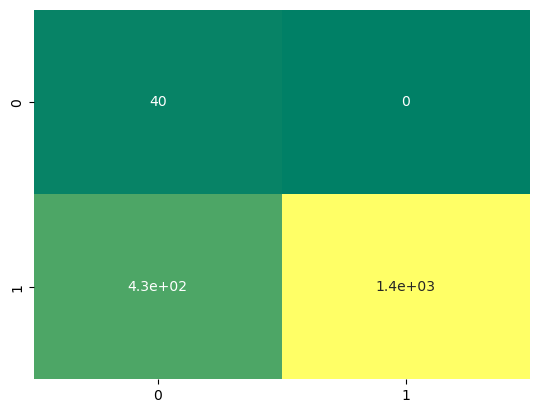

Confusion matrix

 [[  40    0]
 [ 426 1414]]

True Negatives  (TN) =  40
False Positives (FP) =  0
False Negatives (FN) =  426
True Positives  (TP) =  1414


In [55]:
# very simple graph
sns.heatmap(cm, annot=True,cmap='summer',cbar=False)
plt.show()

# add details below graph to help interpret results
print('Confusion matrix\n\n', cm)
print('\nTrue Negatives  (TN) = ', TN)
print('False Positives (FP) = ', FP)
print('False Negatives (FN) = ', FN)
print('True Positives  (TP) = ', TP)


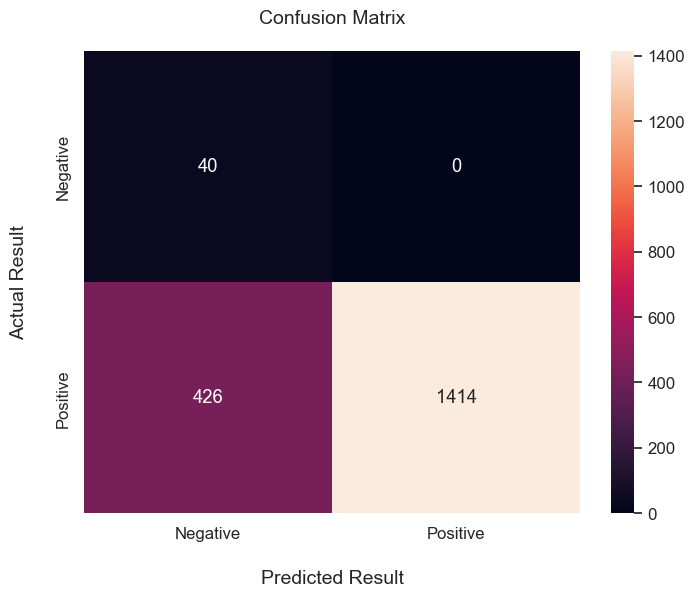

Confusion matrix

 [[  40    0]
 [ 426 1414]]

True Negatives  (TN) =  40
False Positives (FP) =  0
False Negatives (FN) =  426
True Positives  (TP) =  1414


In [56]:
# visualize confusion matrix with slightly more detailed graph
# Example from https://proclusacademy.com/blog/practical/confusion-matrix-accuracy-sklearn-seaborn/

import seaborn as sns


# Change figure size and increase dpi for better resolution
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Result", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Result", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix", fontsize=14, pad=20)

plt.show()


# add details below graph to help interpret results
print('Confusion matrix\n\n', cm)
print('\nTrue Negatives  (TN) = ', TN)
print('False Positives (FP) = ', FP)
print('False Negatives (FN) = ', FN)
print('True Positives  (TP) = ', TP)


Confusion matrix

 [[  40    0]
 [ 426 1414]]

True Negatives  (TN) =  40
False Positives (FP) =  0
False Negatives (FN) =  426
True Positives  (TP) =  1414


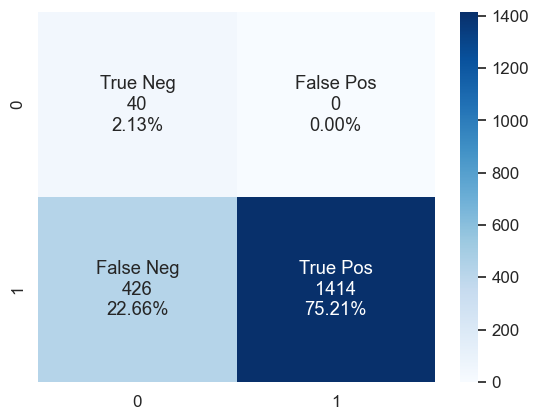

In [57]:
# visualize confusion matrix with more detailed labels
# https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

# add details below graph to help interpret results
print('Confusion matrix\n\n', cm)
print('\nTrue Negatives  (TN) = ', TN)
print('False Positives (FP) = ', FP)
print('False Negatives (FN) = ', FN)
print('True Positives  (TP) = ', TP)


# 16 - Accuracy of model for entire training dataset


In [58]:
# Assign values from confusion matrix to True Positive, True Negative, False Positive, False Negative

print ("True Negatives: ", TN)
print ("False Positives:", FP)
print ("False Negatives:", FN)
print ("True Positives: ", TP)

Accuracy = (( TP + TN) / ( TP + TN + FP + FN))
Sensitivity = TP / (TP + FN)
Specificity = TN / (TN + FP)
GeometricMean = math.sqrt(Sensitivity * Specificity)

print ("")
print ("Accuracy:       ", Accuracy)
print ("Sensitivity:    ", Sensitivity)
print ("Specificity:    ", Specificity)
print ("Geometric Mean: ", GeometricMean)

True Negatives:  40
False Positives: 0
False Negatives: 426
True Positives:  1414

Accuracy:        0.7734042553191489
Sensitivity:     0.7684782608695652
Specificity:     1.0
Geometric Mean:  0.8766289185679225


# 17 - Confusion matrix for each cross validation fold

In [59]:
# define a function to perform a stratified cross validation
# in this context, "stratified" means that for each split performed by the cross-validation, 
# the distribution is preserved in a consistent manner for each split.
# This makes the splits for each CV more consistent with each other, reducing variablity in the scores for a smaller std dev

def cv_confusion_matrix(clf, X, y, folds=10):
    skf = StratifiedKFold(n_splits=folds)
    cv_iter = skf.split(X, y)
    cms = []   #instantiate an empty list
    for train, test in cv_iter:
        clf.fit(X[train,], y[train])
        cm = confusion_matrix(y[test], clf.predict(X[test]), labels=clf.classes_)
        cms.append(cm)
    #return np.mean(np.array(cms), axis=0)  #just show average of each run
    return (np.array(cms))                  #show the confusion matrix for each fold

In [60]:
# xxx
# call the above function
#run the function using the optimal hyperparameter with the training data and target with 10 folds
#this returns a 3-dimensional matrix 
if (modeltype == "TwoClassSVM" or modeltype == "TwoClassKNN"):
    cv_confusion_matrix(clf.best_estimator_,X_train,y_train,10)  
elif (modeltype == "OneClassSVM" or modeltype == "OneClassKNN"):
    #manually create the "classes" attribute for unsupervised models, does not exist by default
    clf.best_estimator_.classes_ = [1,-1]  
    # now you can run the custom function cv_confusion_matrix after definining the "classes" attribute
    cv_confusion_matrix(clf.best_estimator_,X_train,y_train,10)  



In [61]:
# put the 3-dimensional matrix into a variable so we can parse out each cross-validation fold
cms = cv_confusion_matrix(clf.best_estimator_,X_train,y_train,10)  

# show the confusion matrix for the first fold  (will provide TN,FP,FN,TP for a single fold)
cms[0]

array([[16,  0],
       [ 3, 13]], dtype=int64)

# 18 - Accuracy of model for each cross-validation fold


To measure the quality of the models the Accuracy, Sensitivity, Specificity, and the Geometric Mean measurements will be used. 

The Accuracy will give some ideas of the performance on the balanced data set, while Sensitivity and Specificity will help in the final validation stage where the data will be clearly unbalanced.

https://lifenscience.com/sensitivity-specificity-accuracy/
Sensitivity, Specificity, and Accuracy are the terms which are most commonly associated with a Binary classification test and they statistically measure the performance of the test.  Sensitivity indicates, how well the test predicts one category and Specificity measures how well the test predicts the other category. Whereas Accuracy is expected to measure how well the test predicts both categories.


https://en.wikipedia.org/wiki/Sensitivity_and_specificity
Sensitivity and specificity mathematically describe the accuracy of a test which reports the presence or absence of a condition. Individuals for which the condition is satisfied are considered "positive" and those for which it is not are considered "negative".

Sensitivity (true positive rate) refers to the probability of a positive test, conditioned on truly being positive.

Specificity (true negative rate) refers to the probability of a negative test, conditioned on truly being negative.




Calculate the following for each of the cross-validations: Accuracy, Sensitivity, Specificity, Geometric Mean

TP = True Positive

TN = True Negative

FP = False Positive

FN = False Negative

## Formulas:

Accuracy = ( TP + TN) / ( TP + TN + FP + RN)

Sensitivity = TP / (TP + FN)

Specificity = TN / (TP + FP)

Geometric Mean = $$\sqrt{Sensitivity * Specificity}$$



In [62]:
# show the confusion matrix for each cross-validation fold

for i in range(10):
    #
    # Capture True Negative, False Positive, False Negative, True Positive for each cross-validation fold 
    #
    #TN = cms[i][0,0]    #obtain True  Negative value from confusion matrix
    #FP = cms[i][0,1]    #obtain False Positive value from confusion matrix
    #FN = cms[i][1,0]    #obtain False Negative value from confusion matrix
    #TP = cms[i][1,1]    #obtain True  Positive value from confusion matrix
    TN, FP, FN, TP = cms[i].ravel() #use the .ravel function to pull out TN,TP,FN,TP for each fold
    #
    # Calculate Accuracy, Sensitivity, Specificity, Geometric Mean for each cross-validation fold
    #
    Accuracy = ((TP + TN) / (TP + TN + FP + FN))
    Sensitivity = TP / (TP + FN)
    Specificity = TN / (TP + FP)
    GeometricMean = math.sqrt(Sensitivity * Specificity)
    #
    # truncate above calculations to 4 decimal places 
    #
    Accuracy      = round(Accuracy,4)
    Sensitivity   = round(Sensitivity,4)
    Specificity   = round(Specificity,4)
    GeometricMean = round(GeometricMean,4)
    #
    # print output
    #
    print ("\n-------- Cross Validation Fold", i ,"--------")
    print ("True Negative:  ", TN)
    print ("False Positive: ", FP)
    print ("False Negative: ", FN)
    print ("True Positive:  ", TP)
    print ("Accuracy:       ", Accuracy)
    print ("Sensitivity:    ", Sensitivity)
    print ("Specificity:    ", Specificity)
    print ("Geometric Mean: ", GeometricMean)


-------- Cross Validation Fold 0 --------
True Negative:   16
False Positive:  0
False Negative:  3
True Positive:   13
Accuracy:        0.9062
Sensitivity:     0.8125
Specificity:     1.2308
Geometric Mean:  1.0

-------- Cross Validation Fold 1 --------
True Negative:   16
False Positive:  0
False Negative:  3
True Positive:   13
Accuracy:        0.9062
Sensitivity:     0.8125
Specificity:     1.2308
Geometric Mean:  1.0

-------- Cross Validation Fold 2 --------
True Negative:   16
False Positive:  0
False Negative:  3
True Positive:   13
Accuracy:        0.9062
Sensitivity:     0.8125
Specificity:     1.2308
Geometric Mean:  1.0

-------- Cross Validation Fold 3 --------
True Negative:   16
False Positive:  0
False Negative:  2
True Positive:   14
Accuracy:        0.9375
Sensitivity:     0.875
Specificity:     1.1429
Geometric Mean:  1.0

-------- Cross Validation Fold 4 --------
True Negative:   16
False Positive:  0
False Negative:  3
True Positive:   13
Accuracy:        0.9062


# 19 - classification report (f1 score) for entire test dataset

In [63]:
# Classification Report

# Another important report is the Classification report. 
# It is a text summary of the precision, recall, F1 score for each class. 
# Scikit-learn provides facility to calculate Classification report using the classification_report method.

# F1 is the harmonic mean rather than the geometric mean
# F1 gives you the average that is closest to the worst-case scenario

#import classification_report
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.09      1.00      0.16        40
           1       1.00      0.77      0.87      1840

    accuracy                           0.77      1880
   macro avg       0.54      0.88      0.51      1880
weighted avg       0.98      0.77      0.85      1880

